# GRADCAM on MNIST using Keras and Tensorflow

**MNIST DATASET**: The MNIST (Modified National Institute of Standards and Technology) dataset consists of handwritten digits 0 to 9.
 The dataset is made up of 60,000 training images and 10000 testing images each grayscale of size 28×28 pixel

### Importing libraries

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(0) 
import random
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import argparse
import os

##  Reading data

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape, X_test.shape,y_train.shape,y_test.shape)
print(X_train.ndim)
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
print(X_train.ndim)
print(X_train.shape)
print(X_test.shape)

11490434/11490434 [==============================] - 2s 0us/step
(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)
3
4
(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Analysis of dataset

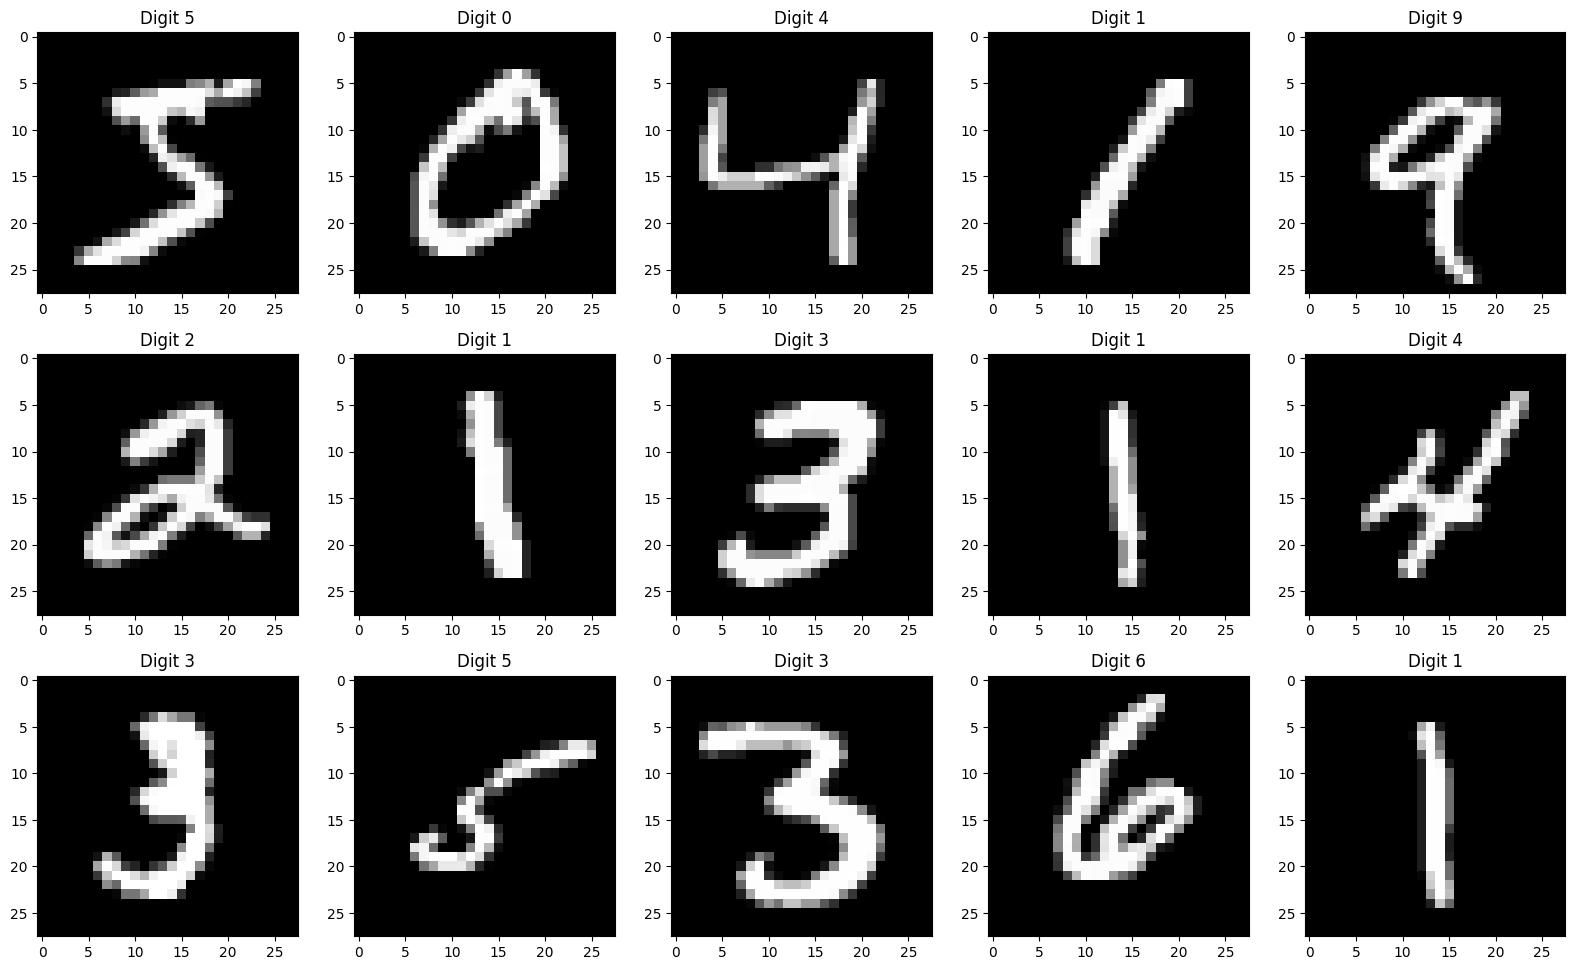

In [ ]:
#Plotting some images from the training dataset along with their labels
def Show_example_digits(mono = 'gray'):
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5,idx+1)
        plt.imshow(X_train[idx], cmap = mono)
        plt.title("Digit {}".format(y_train[idx]))
        
    plt.tight_layout()
    
Show_example_digits()

In [ ]:
# Function return digit in grayscale
X_train_plot = X_train.reshape(-1, 28, 28)
def plot_digit(digit, p = 28, font_size = 10):
    max = font_size * p
    
    fig = plt.figure(figsize=(13, 13))
    plt.xlim([0, max])
    plt.ylim([0, max])
    plt.axis('off')
    black = '#000000'
    
    for i in range(p):
        for j in range(p):

            t = plt.text(i * font_size, max - j*font_size, digit[j][i], fontsize = font_size, color = black)
            c = digit[j][i] / 255.
            t.set_bbox(dict(facecolor=(c, c, c), alpha = 0.5, edgecolor = 'black'))
            
    plt.show()

4


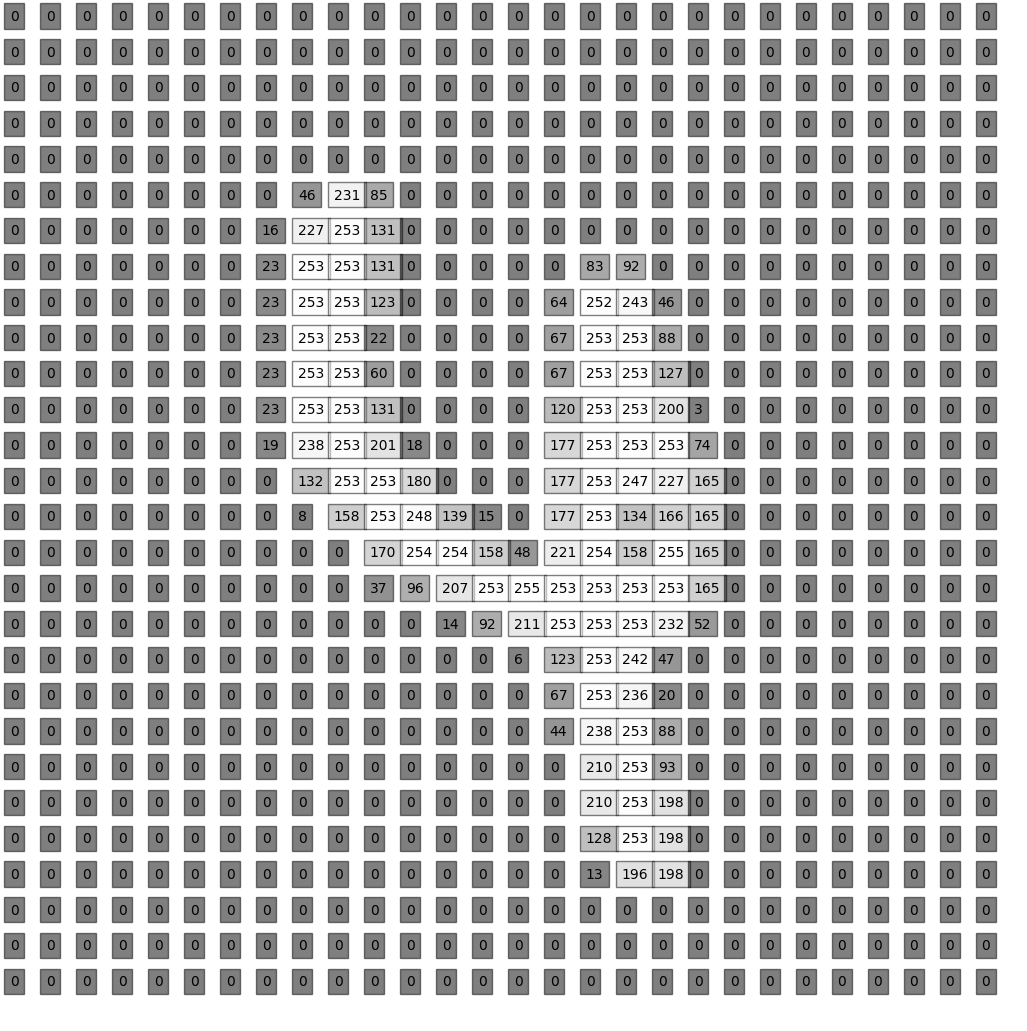

In [ ]:
#Plotting a random image from training dataset along with the values of each pixel of image  
rand_number = random.randint(0, len(y_train))
print(y_train[rand_number])
plot_digit(X_train_plot[rand_number])

## Finding counts of each digits in the dataset

Train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


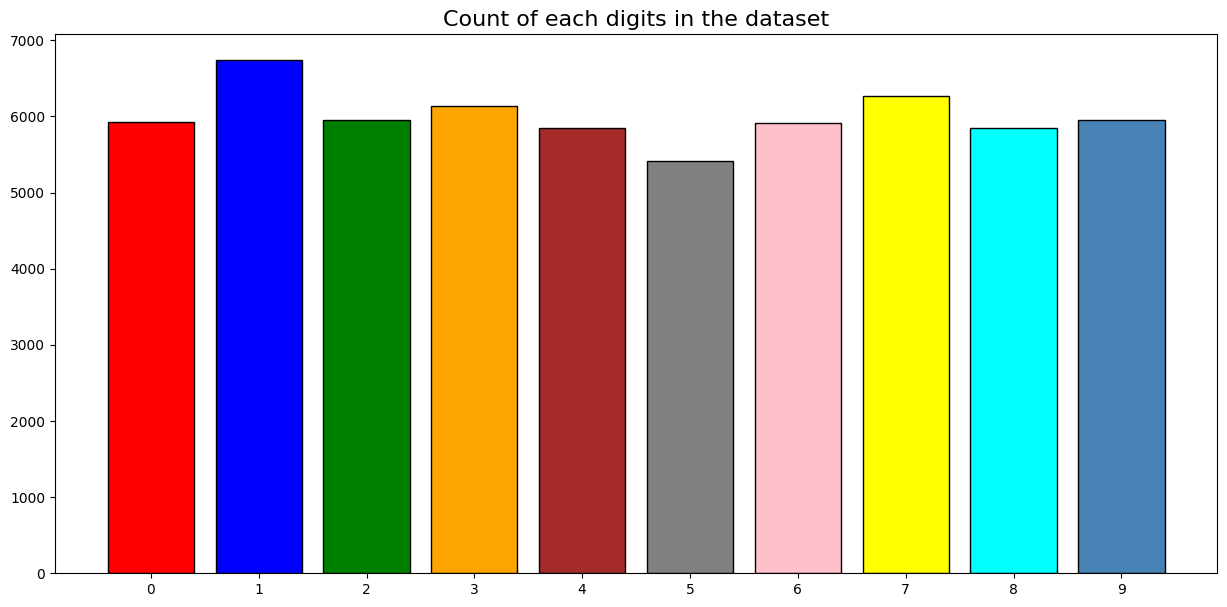

In [ ]:
# count the number of unique train labels
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))

plt.figure(figsize = (15, 7))
plt.title("Count of each digits in the dataset", fontsize = 16)
plt.xticks(range(10))
plt.bar(unique, counts, color = ['red', 'blue', 'green', 'orange', 'brown', 'grey', 'pink', 'yellow', 'cyan', 'steelblue'], edgecolor='black');

# **Data Preprocessing** :

In [ ]:
img_rows, img_cols = 28, 28

num_pixels = X_train.shape[1] 

In [ ]:
#Convert train and test images into 'float32' type
X_train=X_train.astype('float32')
X_test=X_test.astype('float32')

# Data Normalization [0, 1]
X_train /= 255.0 # As we are working on image data we are normalizing data by divinding 255.
X_test /= 255.0

# Convert train and test labels into 'int64' type

y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

# # one-hot encoding for target labels of training and testing dataset
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# | [0, 1, 2, ... , 9] | = 10
num_classes = y_train.shape[1]

# Number of objects, vector size (28 * 28)
print(X_train.shape, X_test.shape)



(60000, 28, 28, 1) (10000, 28, 28, 1)





 **Split dataset into training and validation data**

In [ ]:
# Split train data into train and validation sets with split of 85% training and 15% validaion dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state = 2)
print(X_train.shape, X_test.shape)

(51000, 28, 28, 1) (10000, 28, 28, 1)


# **Building Auxillary Convolutional Neural Network(CNN) model** :

**We will first build and train auxillary model. Then we find suitable value of learning rate that we can obtain for ADAM optimizer**

In [ ]:
input_shape = (28, 28, 1)
def get_cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation = "softmax")
        
    ])

In [ ]:
aux_model = get_cnn()
lr_schedule = keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = keras.optimizers.Adam(learning_rate=1e-4, amsgrad=True)
aux_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
aux_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        36928     
                                                        

In [ ]:
history = aux_model.fit(X_train, y_train,
          batch_size = 128,
          epochs = 25,
          verbose = 1,
          callbacks = [lr_schedule],
          validation_data = (X_val, y_val))

Epoch 1/25
399/399 [==============================] - 17s 15ms/step - loss: 1.1156 - accuracy: 0.6203 - val_loss: 0.2268 - val_accuracy: 0.9322 - lr: 1.0000e-04
Epoch 2/25
399/399 [==============================] - 5s 12ms/step - loss: 0.2948 - accuracy: 0.9125 - val_loss: 0.1251 - val_accuracy: 0.9601 - lr: 1.2589e-04
Epoch 3/25
399/399 [==============================] - 5s 12ms/step - loss: 0.1828 - accuracy: 0.9465 - val_loss: 0.0798 - val_accuracy: 0.9752 - lr: 1.5849e-04
Epoch 4/25
399/399 [==============================] - 6s 14ms/step - loss: 0.1329 - accuracy: 0.9612 - val_loss: 0.0850 - val_accuracy: 0.9751 - lr: 1.9953e-04
Epoch 5/25
399/399 [==============================] - 5s 12ms/step - loss: 0.1058 - accuracy: 0.9691 - val_loss: 0.0554 - val_accuracy: 0.9838 - lr: 2.5119e-04
Epoch 6/25
399/399 [==============================] - 5s 12ms/step - loss: 0.0901 - accuracy: 0.9741 - val_loss: 0.0475 - val_accuracy: 0.9857 - lr: 3.1623e-04
Epoch 7/25
399/399 [===================

In [ ]:
score = aux_model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 2.3040170669555664
Test score: 0.09844444692134857
CNN Error: 90.16%


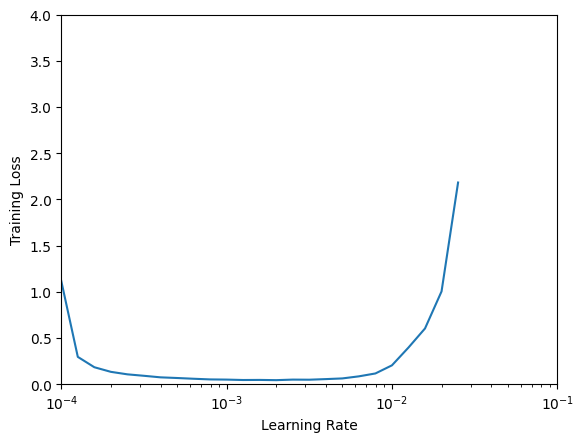

In [ ]:
# Plot Learning Rate vs. Training Loss
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-4, 1e-1, 0, 4])
plt.xlabel('Learning Rate')
plt.ylabel('Training Loss')
plt.show()

**We can see that the loss follows a very specific trajectory: a rapid drop followed by a relatively flat line which shoots back up after a certain point. Thus, it is better to choose a learning rate in the region where the loss is stable; a reasonable choice would be lr = 0.001 (or 1e-3). So, we use these learning rate to train our actual model.**

#### **Data augmentation**: To reduce overfitting we increase the size of the training data by rotating the image, flipping it vertically ov horizontally, scaling, shifting its width or height, zooming in and out. 










In [ ]:
train_aug = ImageDataGenerator(
        rotation_range = 10,  #Randomly rotate images by 10 degrees
        zoom_range = 0.1,     #Randomly Zoom by 10% some images
        width_shift_range = 0.1, #Randomly shift images horizontally by 10% of the width
        height_shift_range = 0.1) #Randomly shift images vertically by 10% of the height
        

train_aug.fit(X_train)
train_gen = train_aug.flow(X_train, y_train, batch_size=64)

# **Building Actual Model** :

**Now we will build our final model using regularizers like Data Augmntation, Dropout, Batch Normlization and Early Stopping. Also we will be using the value of learning rate in ADAM optimizer that we got from the auxillary model.**

**Dropout**: At every iteration, we randomly selects some nodes and removes them along with all of their incoming and outgoing connections. So at each iteration we have a different set of nodes and this results in a different set of outputs. 



**Early Stopping**: When we see that the performance on the validation set is getting worse, we immediately stop the training on the model. This is called Early stopping. If we not used early stopping then after certian point model will start overfitting to the validation dataset.

**Batch Normalization**: In Batch normalization we standardize the inputs so that they have 0 mean and unit standard deviation. It has regularization effect because it is computed over mini-batches and not the entire data set.

In [ ]:
def get_cnn_final():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = (28,28,1)),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
          
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(num_classes, activation = "softmax")
        
    ])
  

In [ ]:
#Checking current directory
# cd 

In [ ]:
model = get_cnn_final()
early_stopping = keras.callbacks.EarlyStopping(patience=8)
filepath='/content/ModelsCheckpoints/Checkpoint.h5'
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath,monitor='val_accuracy', mode='max' , save_best_only=True)#To save best model
optimizer = keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)       

In [ ]:
history = model.fit(train_gen, epochs = 40,
                             verbose=1, 
                               steps_per_epoch = X_train.shape[0] // 64,
                               validation_data = (X_val, y_val),
                               callbacks = [early_stopping, model_checkpoint],
                             )

Epoch 1/40
796/796 [==============================] - 33s 33ms/step - loss: 0.5623 - accuracy: 0.8246 - val_loss: 0.0666 - val_accuracy: 0.9808
Epoch 2/40
796/796 [==============================] - 26s 32ms/step - loss: 0.1469 - accuracy: 0.9583 - val_loss: 0.0540 - val_accuracy: 0.9852
Epoch 3/40
796/796 [==============================] - 25s 32ms/step - loss: 0.1026 - accuracy: 0.9708 - val_loss: 0.0303 - val_accuracy: 0.9913
Epoch 4/40
796/796 [==============================] - 25s 31ms/step - loss: 0.0861 - accuracy: 0.9754 - val_loss: 0.0625 - val_accuracy: 0.9807
Epoch 5/40
796/796 [==============================] - 25s 32ms/step - loss: 0.0766 - accuracy: 0.9784 - val_loss: 0.0264 - val_accuracy: 0.9927
Epoch 6/40
796/796 [==============================] - 24s 30ms/step - loss: 0.0666 - accuracy: 0.9814 - val_loss: 0.0220 - val_accuracy: 0.9924
Epoch 7/40
796/796 [==============================] - 24s 30ms/step - loss: 0.0625 - accuracy: 0.9827 - val_loss: 0.0244 - val_accuracy:

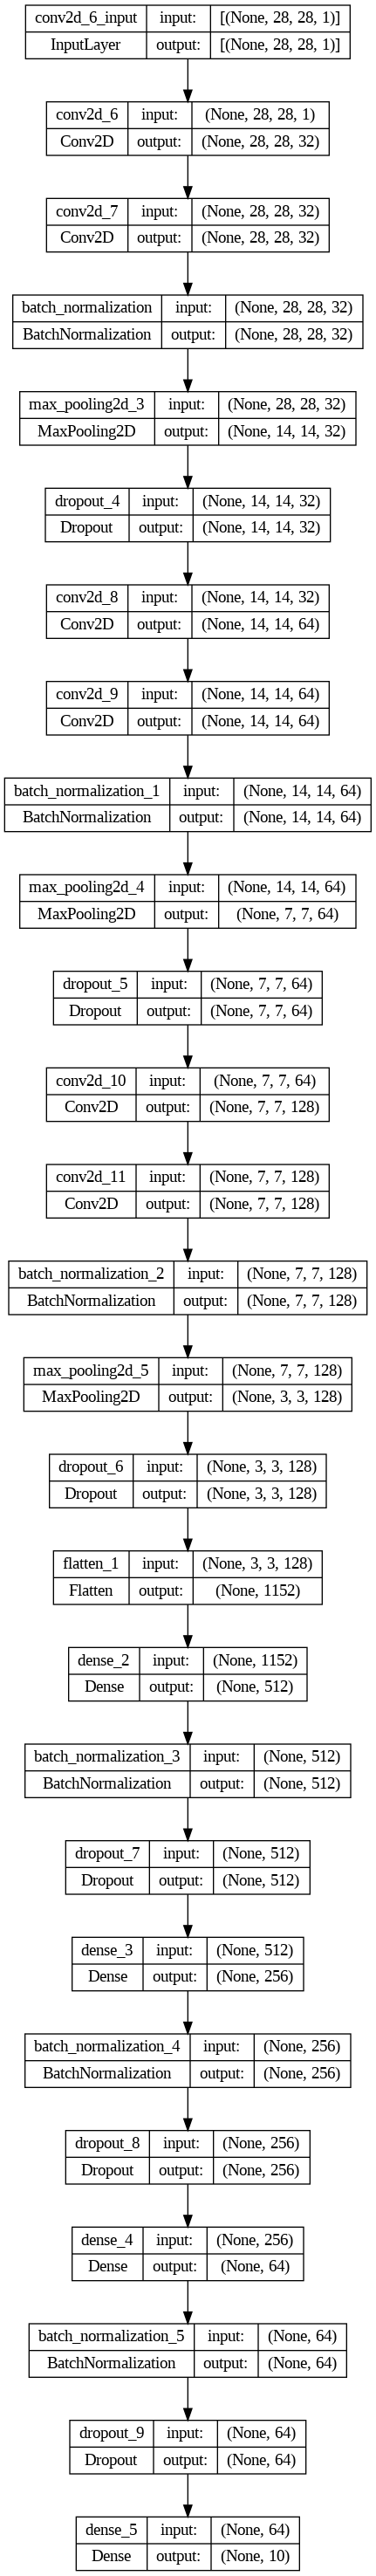

In [ ]:
# Visualize the layers in our final model along with the shape of input and output to each layer
plot_model(model, show_shapes=True)

In [ ]:
# Loading the best model that we saved while training. We will be using this best model only for any evaluation that we will be doing further
model = load_model('/content/ModelsCheckpoints/Checkpoint.h5')

In [ ]:
# Evaluating val loss and val accuracy
score = model.evaluate(X_val, y_val, verbose=0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Val loss: 0.015238089486956596
Val accuracy: 0.996222198009491
CNN Error: 0.38%


In [ ]:
# Accessing the train, test accuracy and loss values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

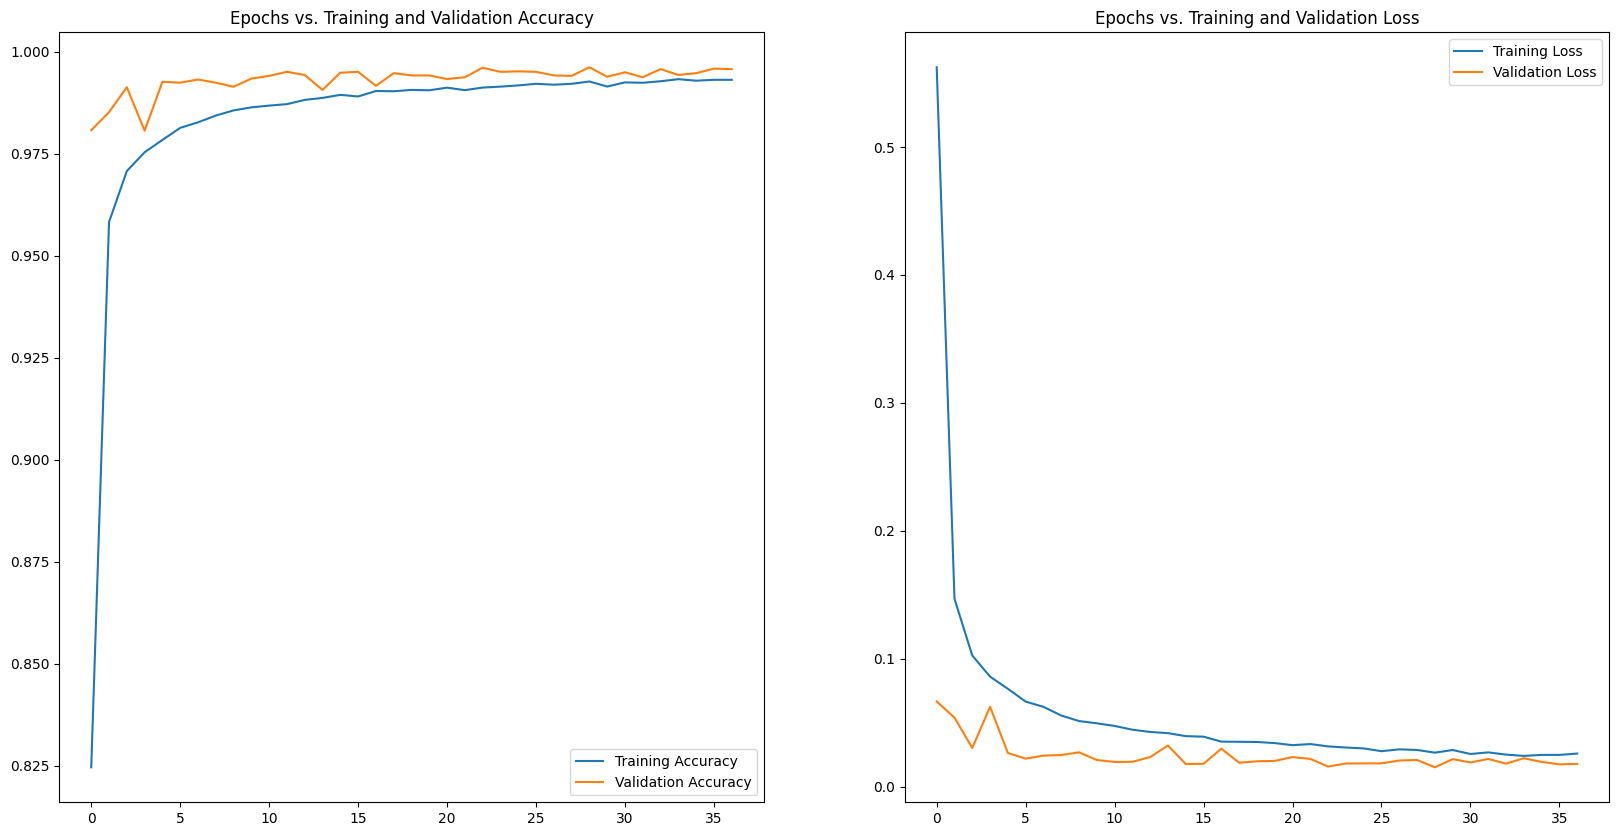

In [ ]:
# Plotting training and validation accuracies and losses

plt.figure(figsize=(20, 10))

# Plotting Epochs vs. training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
  
# Plotting Epochs vs. training and validation losses
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

# **Generate output on TEST Dataset**

In [ ]:
# Evaluate model on test data and predicting test loss and test accuracy
test_loss, test_acc = model.evaluate(x=X_test, y=y_test, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.9956 
Test loss is: 0.0146


**We achieved an accuracy of 99.53% on validataion dataset and accuracy of 99.55% on test dataset(This values will change little bit as we again trained model)**

# **Computting precision, recall, F1 score and Plotting Confusion Matrix**

In [ ]:
# Get predictions and apply inverse transformation to the labels so that 1 hot encoded vector will again transformed to original label vector
print(y_test.shape)
y_test = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(y_test.shape,y_pred.shape)

(10000, 10)
313/313 [==============================] - 1s 3ms/step
(10000,) (10000,)


In [ ]:
# values of precision and recall which will be used in confusion matrix and also give an idea about how our model perform along with detail analysis w.r.t each label
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99      1.00      1.00      1010
           4       1.00      1.00      1.00       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      1.00      1028
           8       1.00      0.99      1.00       974
           9       1.00      1.00      1.00      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



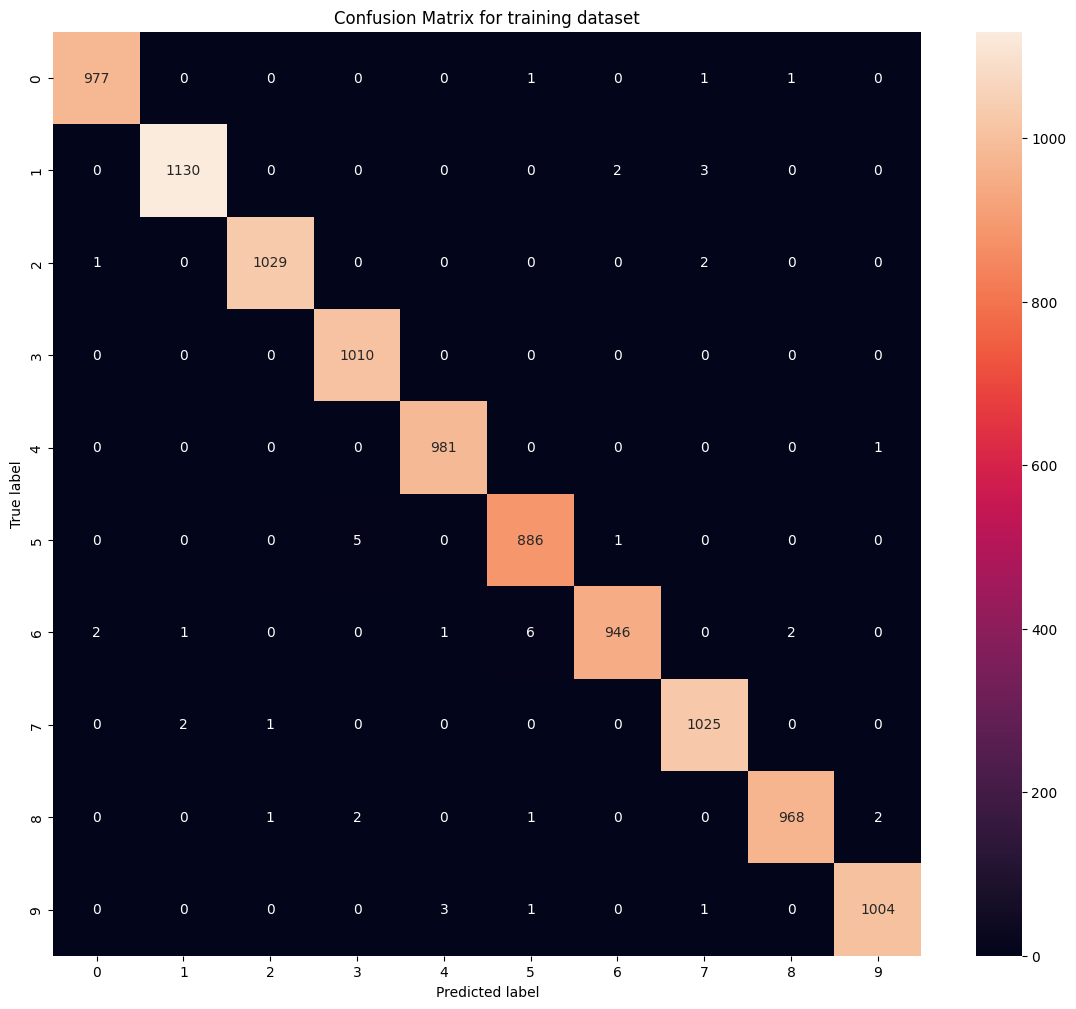

In [ ]:
# Plot the confusion matrix on the test dataset 
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(matrix, annot=True, fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
# Getting the names of the layers in our final CNN model
layer_names = [layer.name for layer in model.layers]
layer_names

['conv2d_6',
 'conv2d_7',
 'batch_normalization',
 'max_pooling2d_3',
 'dropout_4',
 'conv2d_8',
 'conv2d_9',
 'batch_normalization_1',
 'max_pooling2d_4',
 'dropout_5',
 'conv2d_10',
 'conv2d_11',
 'batch_normalization_2',
 'max_pooling2d_5',
 'dropout_6',
 'flatten_1',
 'dense_2',
 'batch_normalization_3',
 'dropout_7',
 'dense_3',
 'batch_normalization_4',
 'dropout_8',
 'dense_4',
 'batch_normalization_5',
 'dropout_9',
 'dense_5']

# **Visualization of model and Interpretation of results using GRADCAM**

**Gradient-weighted Class Activation Mapping(Grad-CAM) visualizes input features that are most likely to generate the target. Grad-CAM uses the gradients of any sample image flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the classification score and output.**

In [ ]:
# To apply GRADCAM on convolutional layers we have to change actiations of last layer of our model from Softmax activation function to linear activation function
from tensorflow.python.keras.activations import linear
model.layers[-1].activation = linear

In [ ]:
from tensorflow.keras.models import Model
import cv2
img_size=(224,224)
def GradCam(model, img_array, layer_name, eps=1e-8):
#     Creates a grad-cam heatmap given a model and a layer name contained with that model

    gradModel = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
# cast the image tensor to a float-32 data type, pass the image through the gradient model, and grab the loss associated with the specific class index
        inputs = tf.cast(img_array, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, 0]
# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
# the convolution and guided gradients have a batch dimension (which we don't need) so let's grab the volume itself and discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
# compute the average of the gradient values, and using them as weights, compute the ponderation of the filters with respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
 # grab the spatial dimensions of the input image and resize the output class activation map to match the input image dimensions
    (w, h) = (500,500)
    heatmap = cv2.resize(cam.numpy(), (w, h))
# normalize the heatmap such that all values lie in the range [0, 1], scale the resulting values to the range [0, 255], and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize):
#     Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    
    heatmap_resized = cv2.resize(cam, img_size)
    if emphasize:
        heatmap_resized = sigmoid(heatmap_resized, 50, thresh, 1)
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap_resized * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img = cv2.cvtColor(superimposed_img,  cv2.COLOR_BGR2RGB)
    return superimposed_img

In [ ]:
#  Function to plot GRADCAM Heatmap of image on layers conv2d11, conv2d10, conv2d9
def plot_GRADCAM(test_input):
#     plotting original sample image
    plt.figure(figsize=(12, 5))
    ax = plt.subplot(1, 4, 1)
    plt.imshow(test_input.squeeze())
    plt.axis('off')
    plt.title('Original Image')

#     plotting GRADCAM Heatmap for conv2d_11 layer
    grad_cam=GradCam(model,test_input,'conv2d_11')
    ax = plt.subplot(1, 4, 2)
    plt.imshow(grad_cam)
    plt.axis('off')
    plt.title('GRAD CAM on conv2d_11')
    
    #     plotting GRADCAM Heatmap for conv2d_10 layer
    grad_cam=GradCam(model,test_input,'conv2d_10')
    ax = plt.subplot(1, 4, 3)
    plt.imshow(grad_cam)
    plt.axis('off')
    plt.title('GRAD CAM on conv2d_10')
    
    #     plotting GRADCAM Heatmap for conv2d_9 layer
    grad_cam=GradCam(model,test_input,'conv2d_9')
    ax = plt.subplot(1, 4, 4)
    plt.imshow(grad_cam)
    plt.axis('off')
    plt.title('GRAD CAM on conv2d_9')


In [ ]:
# Function to plot Superimposed GRADCAM Heatmap onto original image on layers conv2d11, conv2d10, conv2d9 for model interpretation and visualization.
def plot_GRADCAM_superimposed(test_input):
    #     plotting original sample image
    plt.figure(figsize=(12, 5))
    ax = plt.subplot(1, 4, 1)
    plt.imshow(test_input.squeeze())
    plt.axis('off')
    plt.title('Original Image')

    #     plotting Superimposed GRADCAM Heatmap for conv2d_11 layer
    grad_cam=GradCam(model,test_input,'conv2d_11')
    test_input_resized = cv2.resize(test_input.squeeze(), img_size) # (500, 500)
    test_input_resized = cv2.cvtColor(test_input_resized, cv2.COLOR_GRAY2RGB) # (500, 500, 3)
    test_input_resized *= 255
    grad_cam_superimposed = superimpose(test_input_resized, grad_cam, 0.5, emphasize=True)
    ax = plt.subplot(1, 4, 2)
    plt.imshow(grad_cam_superimposed)
    plt.axis('off')
    plt.title('S_Grad-CAM on conv2d_11')
    plt.tight_layout()
    
    #     plotting Superimposed GRADCAM Heatmap for conv2d_10 layer
    grad_cam=GradCam(model,test_input,'conv2d_10')
    test_input_resized = cv2.resize(test_input.squeeze(), img_size) # (500, 500)
    test_input_resized = cv2.cvtColor(test_input_resized, cv2.COLOR_GRAY2RGB) # (500, 500, 3)
    test_input_resized *= 255
    grad_cam_superimposed = superimpose(test_input_resized, grad_cam, 0.5, emphasize=True)
    ax = plt.subplot(1, 4, 3)
    plt.imshow(grad_cam_superimposed)
    plt.axis('off')
    plt.title('S_Grad-CAM on conv2d_10')
    plt.tight_layout()
    
    #     plotting Superimposed GRADCAM Heatmap for conv2d_9 layer
    grad_cam=GradCam(model,test_input,'conv2d_9')
    test_input_resized = cv2.resize(test_input.squeeze(), img_size) # (500, 500)
    test_input_resized = cv2.cvtColor(test_input_resized, cv2.COLOR_GRAY2RGB) # (500, 500, 3)
    test_input_resized *= 255
    grad_cam_superimposed = superimpose(test_input_resized, grad_cam, 0.5, emphasize=True)
    ax = plt.subplot(1, 4, 4)
    plt.imshow(grad_cam_superimposed)
    plt.axis('off')
    plt.title('S_Grad-CAM on conv2d_9')
    plt.tight_layout()


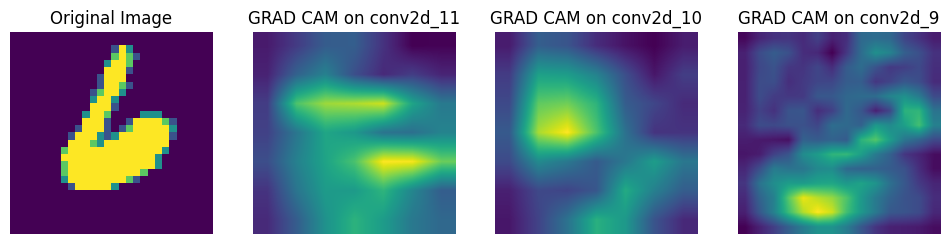

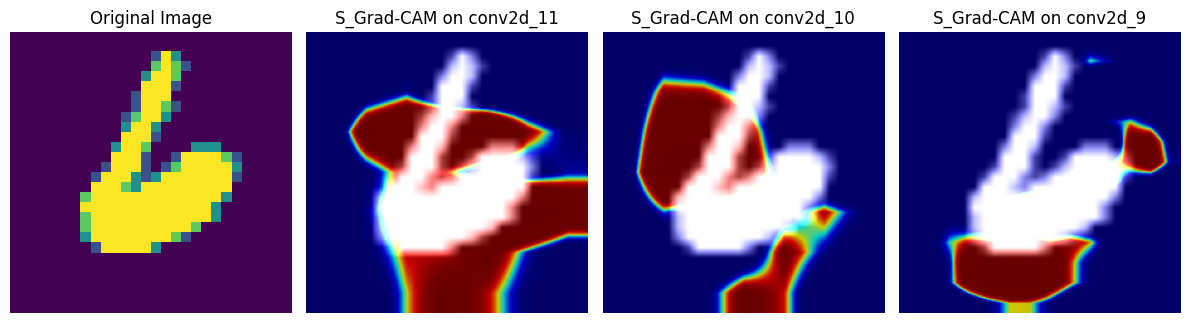

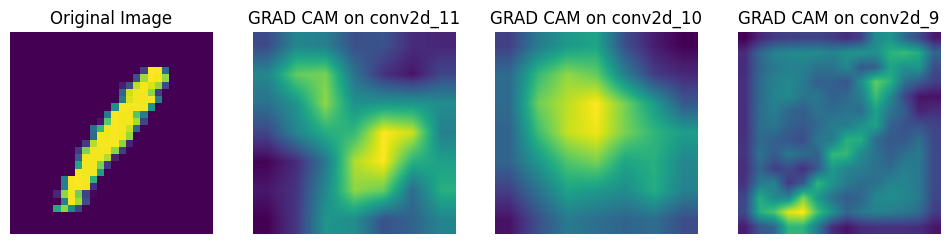

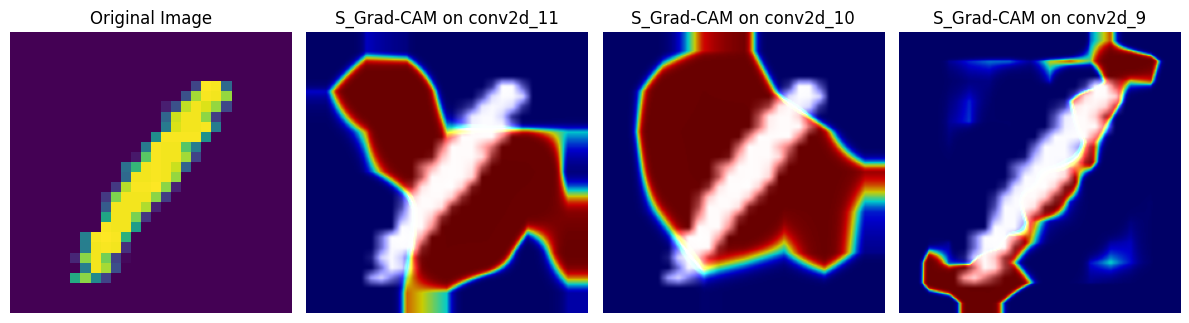

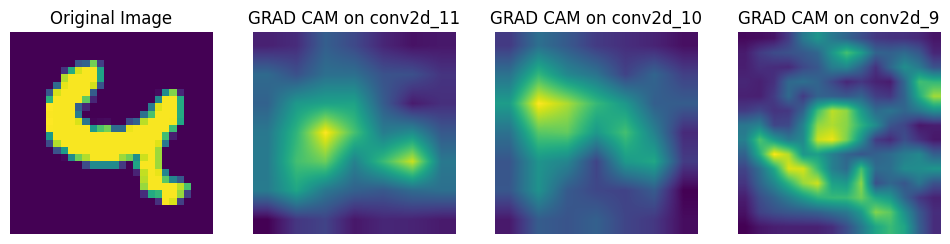

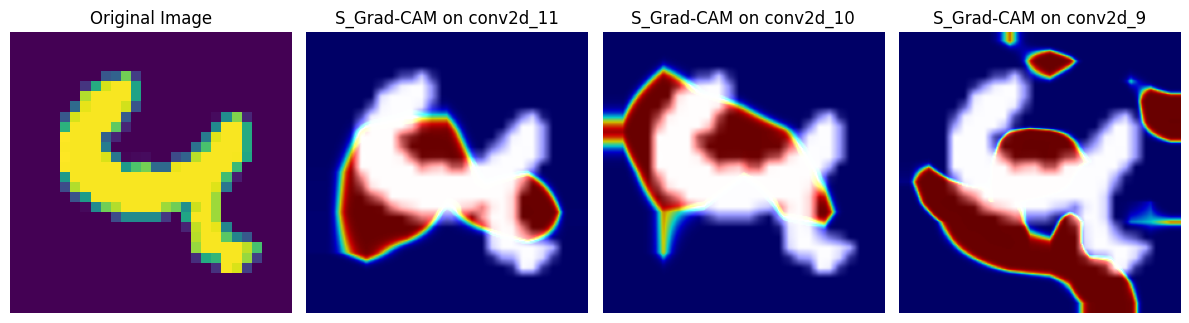

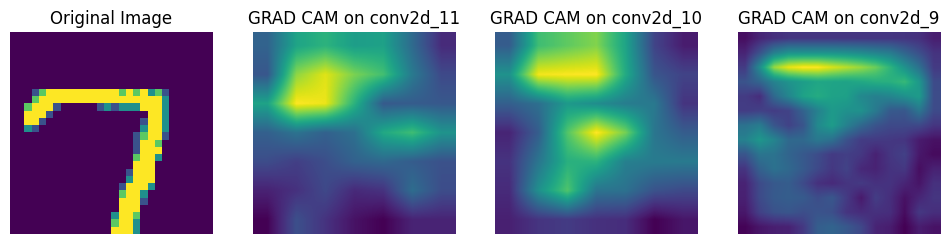

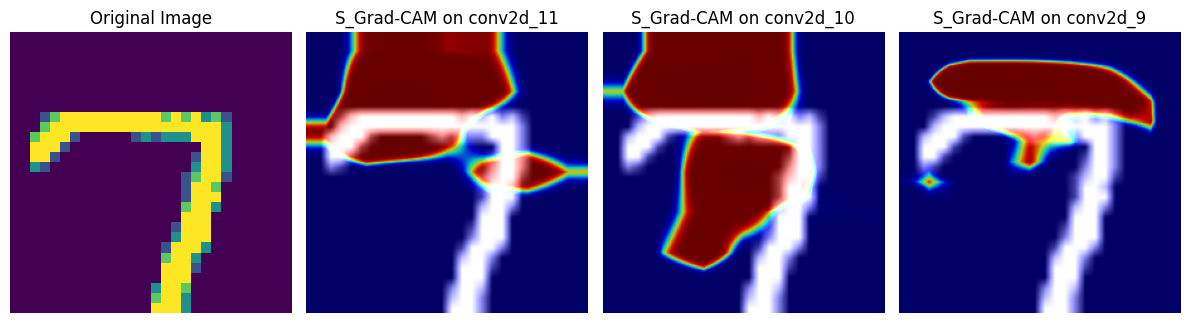

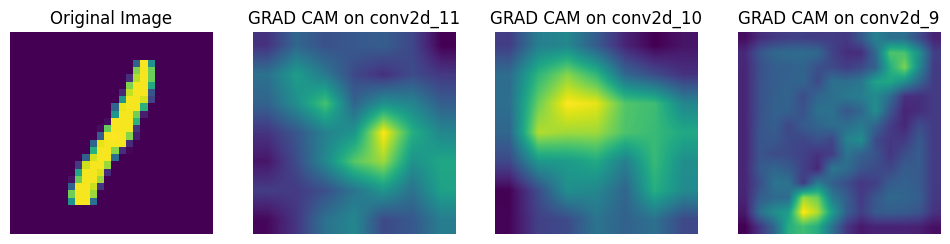

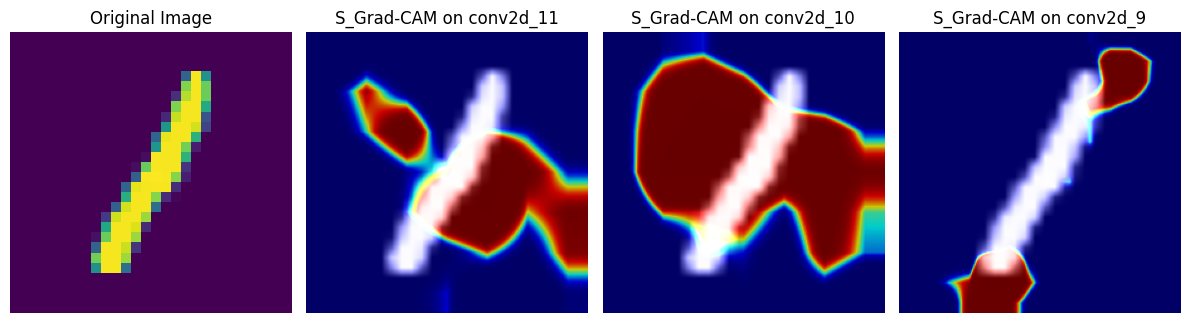

In [ ]:
# S_GRAD_CAM is used for superimposed_GRADCAM as notation in image title
# Taking 5 random images from test dataset as a sample and plotting the sample image as well as GRADCAM output images of last 3 layers of the model.
# GRADCAM is applied only on convolutional layers in the model and not on any other layers like Dropout, BatchNormalization, Dense, max Pooling 
# conv2d_11 is last convolutional layer of the model, conv2d_10 is 2nd last convolutional layer while conv2d_9 is 3rd last convolutional layer of the model.
# The images are plotted in format as follows. 1st a ranom image is selected and then it is passed to plot_GRADCAM function where heatmap for all 3 layers
# is plotted and then same image is passed to plot_GRADCAM_superimposed to plot superimposed GRADCAM heatmap of last 3 layers. For 1 sample of input image,
# plotting of images is done as follow 
# original image, GRADCAM on conv2d_11, GRADCAM on conv2d_10, GRADCAM on conv2d_9(1st line of plottimg for a particular sample)
# original image, S_GRADCAM on conv2d_11, S_GRADCAM on conv2d_10, S_GRADCAM on conv2d_9(2nd line of plottimg for a particular sample)
#  So both these lines show the plotting of same sample
for i in range(5):
    rand_idx = random.randint(0, len(y_test))
    test_input = X_test[rand_idx].reshape(1,X_test.shape[1],X_test.shape[2],1)
    plot_GRADCAM(test_input)
    plot_GRADCAM_superimposed(test_input)

According to me, GRADCAM performs good on last convolutional layer i,e conv2d_11 becuase if we see the output of GRADCAM of conv2d_11 and compare it with outputs of conv2d_10 and conv2d_9 then we can see that conv2d_11 analysed large amount of area contributed to detection of digits in an image in comparison to other 2 layers and we can do these visualization using GRADCAM.Also we can see that in conv2d_11 layer training is done in specific part of image that is this layer only concentrate on specific part of image causing more contribution of this layer to outut score while in ther 2 layers large part of image is concentrated causing less training of particular image part and thereby less contribution of this layer to output score.  
We can also see that localization becomes progressively worse as we move to earlier convolutional layers. This is because later convolutional layers
better capture high-level semantic information while retaining spatial information than earlier layers, that have smaller
receptive fields and only focus on local features